<a href="https://colab.research.google.com/github/fernando-RA/fastaiOnCampus/blob/main/140139281_fernando_RA_Fernando_Ribeiro_Aguilar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Fernando Ribeiro Aguilar; 
_140139281_; 
UnB/FGA


# A02 _ Production _ Which type of race car it is?



# Goals

This article has the goal of training a vision model on top of a dataset of the FIA categories of races. Each different race has a different regulation to make the grand pixes unique, competitive, safe and entertaining..

The Formula One being the fastest and most known category. We will also be training the model on top of images from cars racing formula indy, nascar, wrc rally, le mans, and more.


# Objectives

Utilize the fastAi visionLearner pre-trained model, making a better use of hyperparameter to optimizize the accuracy, export the model weights, and deploy a frontend to our app, making it usable on the world wide web.


# Disclaimer

This is an article with learning purposes, and mistakes are natural to occur. Suggestions on improvements are welcome. Further improvements will be made.





# Technical Aspects

01. Installing dependencies.

Here we will be using fastai and fastbook libraries to train our model on top of their already pre-trained vision model And duckduckgo_search for fetching images

In [2]:
!pip install -Uqq fastbook duckduckgo_search fastai
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

     |████████████████████████████████| 719 kB 8.3 MB/s 
     |████████████████████████████████| 1.3 MB 40.4 MB/s 
     |████████████████████████████████| 451 kB 66.9 MB/s 
     |████████████████████████████████| 5.5 MB 48.0 MB/s 
     |████████████████████████████████| 1.6 MB 13.9 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
     |████████████████████████████████| 96 kB 6.9 MB/s 
     |████████████████████████████████| 212 kB 71.2 MB/s 
     |████████████████████████████████| 182 kB 56.9 MB/s 
     |████████████████████████████████| 115 kB 72.7 MB/s 
     |████████████████████████████████| 127 kB 70.5 MB/s 
     |████████████████████████████████| 7.6 MB 54.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
Mounted at /content/gdrive


# Defining the labels and their respective control image

In [3]:
labels_arr = [
    {"label":'formula one', "img_url": 'https://cdn-1.motorsport.com/images/amp/0oOjXd70/s6/carlos-sainz-jr-ferrari-f1-75-.jpg'}, 
    {"label":'nascar', "img_url": 'https://s.abcnews.com/images/Business/nascar-next-gen-car-02-ht-jef-210505_1620244012862_hpMain_16x9_992.jpg'}, 
    {"label":'formula indy', "img_url": 'https://racemotor.com.br/wp-content/uploads/2021/04/Arrow_McLaren_SP_Montoya_86.jpg'}, 
    {"label":'le mans hypercar', "img_url": 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/wec-2021-studio-005-1610665885.jpg'}, 
    {"label":'le mans gte pro', "img_url": 'https://diecastsociety.com/wp-content/uploads/2022/03/aa81911.jpg'}, 
    {"label":'wrc rally', "img_url": 'https://toyotagazooracing.com/pages/contents/en/wrc/cars/images/2020/car-gallery_image01_L.jpg'}, 
]


## Building the dataset

### Downloading 150 images for each label

In [4]:
folder_path = Path('FIA_Categories')

for data_point in labels_arr:
    destination = (folder_path/data_point["label"])
    destination.mkdir(exist_ok=True, parents=True)
    print('Downloading 100 images for ', data_point["label"])
    download_images(destination, urls=search_images_ddg(data_point["label"], max_images=150))

# Cleaning up the dataset

In [5]:
corrupt_images = verify_images(get_image_files(folder_path))
corrupt_images.map(Path.unlink)
total_corrupted = len(corrupt_images)
print('Amount of corrupted image files removed:')
print(total_corrupted)

Amount of corrupted image files removed:
14


## Building the datablock

One thing worth mentioning is the choice of not using any sort of data augmentation parameter to the datablock, since this was directly impacting the performace of our model during previous runs.

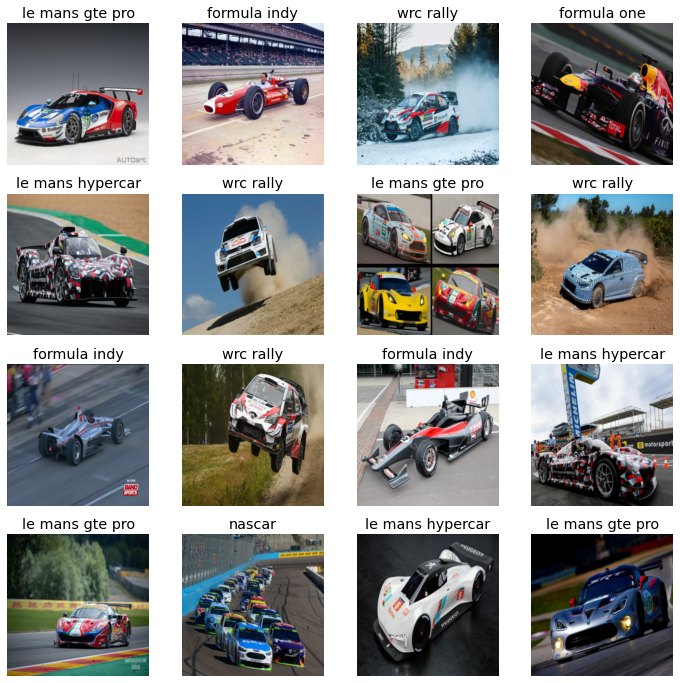

In [6]:
carsDatablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(folder_path, bs=70)

carsDatablock.show_batch(max_n=16)


## Training The vision_learner model

Here we are using the resnet18 as our architecture. Due to efficient training and satisfactory results. Other options would be running resnet34, resnet50, resnet101.

It is worth a performace experiement in the future, observing the results in accuracy for each model and documenting the findings.

With this architecture our final accuracy is 0.860606. 

It still isn't on the 90 lower. which means, not ideal for critical production environments. Since this gives us at least a 10% chance of being wrong in our predictions.



In [7]:
learn = vision_learner(carsDatablock, resnet18, metrics=accuracy, normalize=True)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.433008,0.986291,0.636364,01:01


epoch,train_loss,valid_loss,accuracy,time
0,0.904071,0.575501,0.806061,01:00
1,0.596842,0.419125,0.872727,00:58
2,0.407968,0.385618,0.860606,00:59
3,0.303540,0.379656,0.860606,01:01


## Confusion Matrix

Here we notice a fair confusion between formula indy and formula one, which is understandable since both cars run on pretty similar body kit


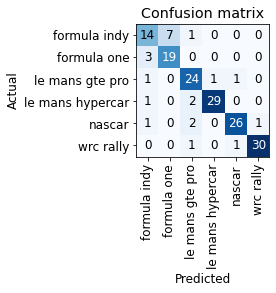

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

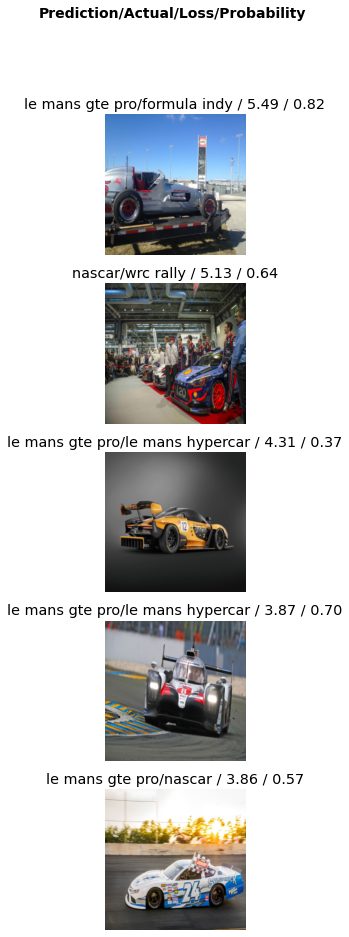

In [9]:
interp.plot_top_losses(5, nrows=5)


In [10]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [11]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), folder_path)
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

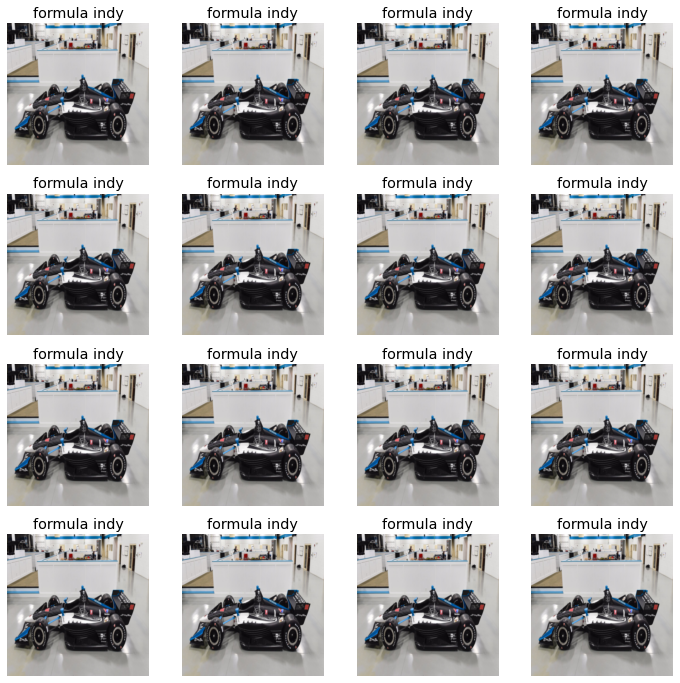

In [12]:
carsDatablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
)

dataloaders = carsDatablock.dataloaders(folder_path, bs=70)
dataloaders.show_batch(max_n=16, unique=True)

## Re-training the model 

After cleaning up some data and manually labeling others. I wanted to define if training the model again would result in a significant change in the accuracy metric. Which proved to be an inconsistent thesis.

In [13]:
learn = vision_learner(dataloaders, resnet18, metrics=accuracy, normalize=True)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.438628,0.990449,0.618182,01:01


epoch,train_loss,valid_loss,accuracy,time
0,0.919460,0.563506,0.812121,00:57
1,0.625787,0.423939,0.854545,00:57
2,0.423691,0.426208,0.836364,00:59
3,0.307226,0.419647,0.848485,01:00


# Exporting the model

Since we want to be able to run this project in a fairly low capacity computers, this would mean, exporting the model's wheights and importing the already trained model onto a web app. Which allows us to make predictions fast instead of needing a GPU

In [14]:
learn.export()

In [15]:

path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [16]:
learn_inf = load_learner(path/'export.pkl')


# Using the exported model to make preditions based on our control images


In the beginning of this article we were exporting previously labeled images for each category. Now we are using our trained model to classify and evaluate these labels to test the effectivity of the same.

In [17]:
from fastdownload import download_url
import re

regex_pattern = r'^(.*[\\\/])'

sample_path = Path('sample_data')

for data_point in labels_arr:
    test_destination = (sample_path/data_point["label"])
    test_destination.mkdir(exist_ok=True, parents=True)
    download_url(data_point["img_url"], '', show_progress=True)
    file_name = re.sub(regex_pattern, '', data_point["img_url"])
    # learn_inf
    result,_,probs = learn_inf.predict(PILImage.create(file_name))
    print(f'Correct label: {data_point["label"]},  ML Prediction: {result}.')


Correct label: formula one,  ML Prediction: formula one.


Correct label: nascar,  ML Prediction: wrc rally.


Correct label: formula indy,  ML Prediction: formula indy.


Correct label: le mans hypercar,  ML Prediction: le mans hypercar.


Correct label: le mans gte pro,  ML Prediction: le mans hypercar.


Correct label: wrc rally,  ML Prediction: wrc rally.


In [18]:
learn_inf.dls.vocab


['formula indy', 'formula one', 'le mans gte pro', 'le mans hypercar', 'nascar', 'wrc rally']

In [19]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [22]:
btn_upload = SimpleNamespace(data = ['car-gallery_image01_L.jpg'])


In [23]:
img = PILImage.create(btn_upload.data[-1])


In [24]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl


Output()

In [25]:
pred,pred_idx,probs = learn_inf.predict(img)


In [26]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: wrc rally; Probability: 0.9893')

In [27]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [28]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [29]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [30]:
#hide_output
VBox([widgets.Label('Select your Car!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [31]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

# Creating our frontend App


In [32]:
# Add your notebook to a GitHub repository.
# Paste the URL of that repo into Binder's URL, as shown in <>.
# Change the File dropdown to instead select URL.
# In the "URL to open" field, enter /voila/render/name.ipynb (replacing name with the name of for your notebook).
# Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe.
# Click Launch.